# Exercise Notes:

This exercise exemplifies the use of a first causal model that is WRONG because it leaves out an important variable (either because we don't know about it or because we **believe** it does not have an effect on the outcome).

- Our **outcome** again is students' `grades`.
- We aim to estimate the causal effect that the "*treatment*" `private tutoring` has on students' grades (**effect**).
- We **believe** that `study hours` (per week) is the only variable that affects both tutoring and grades (i.e., it is a **confounder**)

The exercise will show how to **detect that the model is wrong** and how once corrected it estimates the effect properly.

Note: remember that a confounder `Z` affects both the cause `X` and the effect/outcome `Y`.

## Code notes: 
First we install and import the necessary packages.

%%capture hides cell output

In [134]:
%%capture
%pip install dowhy matplotlib

In [135]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dowhy import CausalModel

## Generate synthetic data

We generate a synthetic data with different random values. As you can see parental_involvement is biased with 0.7 prob. assigned to 0 and 0.3 assinged to 1. 

In the last two lines we fill tutoring and grade as we have synthetically made them to depend on the study hours and parental involvement.

Assume that instead of being synthetically created this data was given to you from data collection (e.g. via surveys). 

In [136]:
# Generate synthetic data
np.random.seed(0)
data = pd.DataFrame({
    "study_hours": np.random.normal(5, 1, 1000),  # Study hours
    "parental_involvement": np.random.choice([0, 1], size=1000, p=[0.7, 0.3]),  # Parental involvement level
    "tutoring": np.zeros(1000),  # Placeholder for tutoring
    "grade": np.zeros(1000)  # Placeholder for grade
})

# Assume tutoring is influenced by both study hours and parental involvement
data["tutoring"] = (data["study_hours"] + 10 * data["parental_involvement"] + np.random.normal(0, 1, 1000) > 6).astype(int)
data["grade"] = 50 + 10 * data["tutoring"] + 5 * data["study_hours"] + 10 * data["parental_involvement"] + np.random.normal(0, 2, 1000)

- Tutoring is a boolean variable, (either 0 or 1) but depends on the number of studying hours and parental involvement + random normal noise.
- As you can see in the "*equation*" the effect (on the grades) of tutoring is 10 points when true. But parental involvement has also an strong effect.

Our data shows that having 1s in tutoring don't mean 1s in parental_involvement (or viceversa)

In [137]:
data.tail(10)

,study_hours,parental_involvement,tutoring,grade
990,5.441033,0,1,86.784749
991,5.178793,0,0,75.005558
992,4.200578,1,1,92.496516
993,5.240788,0,0,74.929059
994,5.289121,1,1,98.189120
995,5.412871,0,0,77.813355
996,4.801601,0,0,76.318058
997,5.094192,1,1,96.811745
998,3.852389,0,0,67.153054
999,4.641886,0,0,71.478162


## Creating our initial causal model

Below we have our **initial causal model** in which we **wrongly** assume that `parental involvement` does not affect anything else. 

Again, the reasons for this error could be two:

- We don't know about this variable. So we didn't even captured it to begin with (e.g. we didn't ask in the survey). 
- We captured this variable (but we asked so many things in our survey !) but we believe not to affect the other variables.

Note that, whether unknown to us or wrongly assumed by us, variables can be affected by `parental involvement` in reality.

The model shows that `study hours` is a **confounder** of both `tutoring` and `grade`.

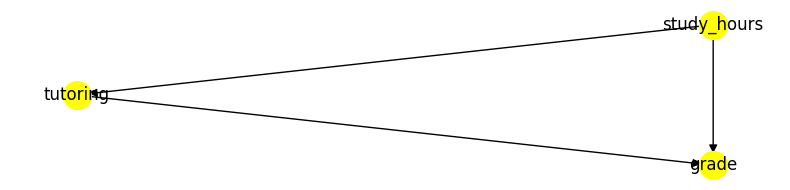

In [138]:
# Create a causal model excluding parental involvement initially
model = CausalModel(
    data=data,
    treatment="tutoring",
    outcome="grade",
    common_causes=["study_hours"]
)

# Visualize the causal graph
model.view_model(size=(8,2))
plt.tight_layout(w_pad=1)

## Initial results

Our initial results show an estimated effect of 14.98 meaning that having `private tutoring` is estimated to increase a student’s final `grade` by approximately 17 points.

This effect estimate was obtained after controlling for `study hours` but without considering the additional confounder `parental involvement`.

At this point we could be naively happy with this result. But what if we are overestimating or underestimating the effect of `tutoring`?

In [139]:
%%capture
# Estimate effect
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

In [140]:
print("Estimated Effect (initial model):", estimate.value)

Estimated Effect (initial model): 17.585373682989484


### Placebo test

The placebo test replaces the actual treatment (in this case, `tutoring`) with a "placebo" or random variable that has no relationship to the outcome (final `grade`).

**Results and interpretation:**

- New effect (0.0): Since the placebo treatment produces a 0 effect on final grades, as expected, it indicates that random noise (from the placebo) does not affect `grades`. This supports the validity of the original model in terms of structural setup.

- Original effect (14.98) vs. New effect (0.0): The difference between the estimated effect of 14.98 (when using `tutoring`) and 0.0 (when using a placebo) implies that the observed effect likely stems from a real relationship between `tutoring` and `grades` rather than random bias.

- p-value (2.0): This high p-value means there’s no statistically significant effect with the placebo treatment, further suggesting that the original estimate of 14.98 is not due to chance.

The placebo test here suggests that the original model’s structure is robust, meaning that the observed effect of tutoring on grades is not due to random bias. However, because this estimate was obtained without adjusting for parental_involvement, **the result could still be biased due to an unmeasured confounder**.



In [141]:
%%capture
# Perform placebo test
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")

In [142]:
print("Placebo Test Result:", refutation)

Placebo Test Result: Refute: Use a Placebo Treatment
Estimated effect:17.585373682989484
New effect:0.0
p value:2.0



### Bootstrap Validation: 

Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

The effect does not deviate much from the original estimated effect. Still, something else could be going on.

In [143]:
%%capture
bootstrap_refutation = model.refute_estimate(identified_estimand, estimate, method_name="bootstrap_refuter")

In [144]:
print(bootstrap_refutation)

Refute: Bootstrap Sample Dataset
Estimated effect:17.585373682989484
New effect:17.616872980690538
p value:0.8



### Adding an unobserved common cause

Add Unobserved Common Causes: How sensitive is the effect estimate when we add an additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? (Hint: It should not be too sensitive)

In this case we see a huge drop. This may indicate that we over estimated the effect of `tutoring` on the `grades` and that we are missing an important confounder.

In [145]:
%%capture
sensitivity_analysis = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause")

In [146]:
print(sensitivity_analysis)

Refute: Add an Unobserved Common Cause
Estimated effect:17.585373682989484
New effect:3.0797827732011314



## Rethinking our model

We get back to the table and see that we missed an important variable. `Parental involvement`. We either ask the students again or if we already had this variable in our surveys we add it to the model as a confounder affecting the `grades` and the `tutoring`. Note that in "our reality" `parental involvement` did not affect `study hours` directly.

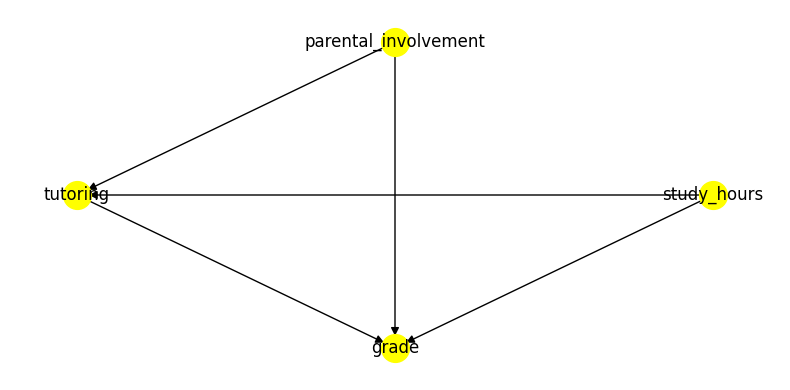

In [147]:
# Realize missing confounder: Parental involvement
model_with_confounder = CausalModel(
    data=data,
    treatment="tutoring",
    outcome="grade",
    common_causes=["study_hours", "parental_involvement"]
)

# Visualize the causal graph
model_with_confounder.view_model(size=(8,4))
plt.tight_layout()

In [148]:
%%capture
# Re-estimate with revised model
identified_estimand_with_confounder = model_with_confounder.identify_effect()
estimate_with_confounder = model_with_confounder.estimate_effect(identified_estimand_with_confounder, method_name="backdoor.linear_regression")

In [149]:
print("Estimated Effect (revised model):", estimate_with_confounder.value)

Estimated Effect (revised model): 10.095828768814414
